In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

import math

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

from torchaudio.datasets import SPEECHCOMMANDS
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
val_set = SubsetSC("validation")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

  0%|          | 0.00/2.26G [00:00<?, ?B/s]

In [4]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))

In [5]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

In [6]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]

In [7]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [8]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=128):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 4 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(4 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.conv5 = nn.Conv1d(4 * n_channel, 8 * n_channel, kernel_size=1)
        self.bn5 = nn.BatchNorm1d(8 * n_channel)
        self.conv6 = nn.Conv1d(8 * n_channel, 16 * n_channel, kernel_size=1)
        self.bn6 = nn.BatchNorm1d(16 * n_channel)
        self.fc1 = nn.Linear(16 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = self.conv5(x)
        x = F.relu(self.bn5(x))
        x = self.conv6(x)
        x = F.relu(self.bn6(x))

        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


model = M5(n_input=waveform.shape[0], n_output=len(labels))
model.to(device)
#print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)


Number of parameters: 3256355


In [9]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

In [10]:
def train(epoch, log_interval):
    model.train()

    total_loss = 0.
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # record loss
        losses.append(loss.item())
        

In [11]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)

@torch.no_grad()
def evaluate(data_source):
    model.eval()
    total_loss = 0.
    correct = 0
    n = 0
    for data, target in data_source:
        data = data.to(device)
        target = target.to(device)

        data = transform(data)
        output = model(data)

        total_loss += target.numel() * F.nll_loss(output.squeeze(), target).item()
        n += target.numel()


        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        #print(pred)
        #print(target)
    

    accuracy = 100 * correct / len(test_loader.dataset)
    
    return total_loss / n, accuracy

        

In [12]:
best_val_loss = float("inf")
losses = []

log_interval = 100
n_epoch = 10

for epoch in range(1, n_epoch + 1):
    train(epoch, log_interval)
    val_loss, val_acc = evaluate(val_loader)

    print(f'| Validation | val loss {val_loss:5.2f} | val accuracy {val_acc:.0f}%')

    if val_loss < best_val_loss:
      with open("best_checkpoint_CNN.pth", 'wb') as f:
        torch.save(model, f)
      best_val_loss = val_loss
    scheduler.step()

with open("best_checkpoint_CNN.pth", 'rb') as f:
  model = torch.load(f)

with torch.no_grad():
  test_loss, test_acc = evaluate(test_loader)
    
#print('=' * 89)
print(f'| End of training | test loss {test_loss:5.2f} | test accuracy {test_acc:.0f}%')
#print('=' * 89)

# Let's plot the training loss versus the number of iteration.
#plt.plot();
#plt.title("training loss");

Train Epoch: 1 [0/84843 (0%)]	Loss: 3.648692
Train Epoch: 1 [25600/84843 (30%)]	Loss: 2.803075
Train Epoch: 1 [51200/84843 (60%)]	Loss: 1.931722
Train Epoch: 1 [76800/84843 (90%)]	Loss: 1.425073
| Validation | val loss  1.63 | val accuracy 46%
Train Epoch: 2 [0/84843 (0%)]	Loss: 1.432212
Train Epoch: 2 [25600/84843 (30%)]	Loss: 1.008565
Train Epoch: 2 [51200/84843 (60%)]	Loss: 0.965936
Train Epoch: 2 [76800/84843 (90%)]	Loss: 1.053282
| Validation | val loss  1.09 | val accuracy 61%
Train Epoch: 3 [0/84843 (0%)]	Loss: 0.842421
Train Epoch: 3 [25600/84843 (30%)]	Loss: 0.929406
Train Epoch: 3 [51200/84843 (60%)]	Loss: 0.823472
Train Epoch: 3 [76800/84843 (90%)]	Loss: 0.741435
| Validation | val loss  0.81 | val accuracy 68%
Train Epoch: 4 [0/84843 (0%)]	Loss: 0.728939
Train Epoch: 4 [25600/84843 (30%)]	Loss: 0.671482
Train Epoch: 4 [51200/84843 (60%)]	Loss: 0.789284
Train Epoch: 4 [76800/84843 (90%)]	Loss: 0.578844
| Validation | val loss  0.78 | val accuracy 69%
Train Epoch: 5 [0/84843 

| End of training | test loss  0.70 | test accuracy 80%


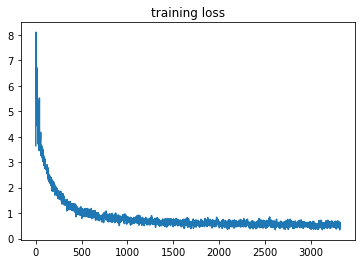

In [13]:
print(f'| End of training | test loss {test_loss:5.2f} | test accuracy {test_acc:.0f}%')

plt.plot(losses);
plt.title("training loss");

In [14]:
from google.colab import files
files.download("best_checkpoint_CNN.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>